**GENERATING DATA SET**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

In [3]:
np.random.seed(42)
n_samples = 50000

# Generate features with realistic distributions
data = {
    'loan_id': range(1, n_samples + 1),
    'loan_amount': np.random.gamma(shape=2, scale=5000, size=n_samples).astype(int),
    'annual_income': np.random.gamma(shape=3, scale=20000, size=n_samples).astype(int),
    'employment_length': np.random.choice([0, 1, 2, 3, 4, 5, 7, 10, 15, 20], size=n_samples, 
                                         p=[0.05, 0.08, 0.10, 0.12, 0.15, 0.15, 0.15, 0.10, 0.07, 0.03]),
    'home_ownership': np.random.choice(['RENT', 'OWN', 'MORTGAGE'], size=n_samples, 
                                      p=[0.40, 0.20, 0.40]),
    'purpose': np.random.choice(['debt_consolidation', 'credit_card', 'home_improvement', 
                                'major_purchase', 'small_business', 'other'], 
                               size=n_samples, p=[0.35, 0.25, 0.15, 0.10, 0.08, 0.07]),
    'credit_score': np.random.normal(loc=680, scale=80, size=n_samples).astype(int),
    'open_credit_lines': np.random.poisson(lam=8, size=n_samples),
    'total_credit_limit': np.random.gamma(shape=2, scale=15000, size=n_samples).astype(int),
    'revolving_balance': np.random.gamma(shape=1.5, scale=3000, size=n_samples).astype(int)
}

df = pd.DataFrame(data)

# Clip values to realistic ranges
df['loan_amount'] = df['loan_amount'].clip(1000, 40000)
df['annual_income'] = df['annual_income'].clip(20000, 250000)
df['credit_score'] = df['credit_score'].clip(300, 850)
df['open_credit_lines'] = df['open_credit_lines'].clip(1, 25)
df['total_credit_limit'] = df['total_credit_limit'].clip(5000, 150000)
df['revolving_balance'] = df['revolving_balance'].clip(0, 50000)

# Calculate interest rate based on credit score (realistic relationship)
df['interest_rate'] = 30 - (df['credit_score'] / 30) + np.random.normal(0, 1.5, n_samples)
df['interest_rate'] = df['interest_rate'].clip(5.5, 25.0).round(2)

# Calculate loan term (months)
df['loan_term'] = np.random.choice([36, 60], size=n_samples, p=[0.70, 0.30])

# Create debt-to-income ratio
df['dti'] = (df['revolving_balance'] / (df['annual_income'] / 12)).clip(0, 45).round(2)

# Generate loan status with realistic default probability based on risk factors
default_prob = (
    0.05 +  # Base default rate
    0.002 * (df['interest_rate'] - 12) +  # Higher interest = higher risk
    0.0003 * (df['dti'] - 15) +  # Higher DTI = higher risk
    0.0001 * (700 - df['credit_score']) +  # Lower credit score = higher risk
    0.002 * (df['loan_amount'] / df['annual_income']) -  # Higher loan-to-income = higher risk
    0.001 * df['employment_length']  # Longer employment = lower risk
)

default_prob = default_prob.clip(0.02, 0.40)
df['loan_status_raw'] = np.random.binomial(1, default_prob)
df['loan_status'] = df['loan_status_raw'].map({0: 'Fully Paid', 1: 'Default'})

# Add some missing values to make it realistic
missing_indices = np.random.choice(df.index, size=int(0.03 * n_samples), replace=False)
df.loc[missing_indices[:len(missing_indices)//3], 'employment_length'] = np.nan
df.loc[missing_indices[len(missing_indices)//3:2*len(missing_indices)//3], 'dti'] = np.nan
df.loc[missing_indices[2*len(missing_indices)//3:], 'revolving_balance'] = np.nan

# Drop temporary column
df = df.drop('loan_status_raw', axis=1)

print(f"✓ Generated {len(df):,} loan records")
print(f"✓ Features: {len(df.columns)} columns")


✓ Generated 50,000 loan records
✓ Features: 14 columns


**LOAD AND INSPECT DATA**

In [8]:
print(df.head())
print("\n")
print(df.info())
print("\n")
print(df.describe())


   loan_id  loan_amount  annual_income  employment_length home_ownership  \
0        1        11968          34898                7.0           RENT   
1        2         7472          50464                4.0       MORTGAGE   
2        3         6911          68471               10.0       MORTGAGE   
3        4         6911          80203                7.0           RENT   
4        5        23248          93083                2.0           RENT   

              purpose  credit_score  open_credit_lines  total_credit_limit  \
0         credit_card           630                  5               43368   
1  debt_consolidation           727                 12               16856   
2  debt_consolidation           588                 14                6299   
3    home_improvement           758                  6               19471   
4         credit_card           484                  9                5000   

   revolving_balance  interest_rate  loan_term   dti loan_status  \
0     

**DATA CLEANING**

In [9]:
# Check missing values
print("Missing values before cleaning:")
print(df.isnull().sum())

# Fill missing values
df['employment_length'].fillna(df['employment_length'].median(), inplace=True)
df['dti'].fillna(df['dti'].median(), inplace=True)
df['revolving_balance'].fillna(df['revolving_balance'].median(), inplace=True)

print("\n✓ Missing values handled")
print(f"✓ Remaining nulls: {df.isnull().sum().sum()}")

# Encode loan status for modeling
df['loan_status_encoded'] = df['loan_status'].map({'Fully Paid': 0, 'Default': 1})
print(f"\n✓ Loan Status Distribution:")
print(df['loan_status'].value_counts())
print(f"Default Rate: {df['loan_status_encoded'].mean():.2%}")

Missing values before cleaning:
loan_id                0
loan_amount            0
annual_income          0
employment_length      0
home_ownership         0
purpose                0
credit_score           0
open_credit_lines      0
total_credit_limit     0
revolving_balance      0
interest_rate          0
loan_term              0
dti                    0
loan_status            0
loan_status_encoded    0
dtype: int64

✓ Missing values handled
✓ Remaining nulls: 0

✓ Loan Status Distribution:
loan_status
Fully Paid    48269
Default        1731
Name: count, dtype: int64
Default Rate: 3.46%


**EXPLORATORY DATA ANALYSIS**

✓ EDA visualizations saved as 'eda_analysis.png'


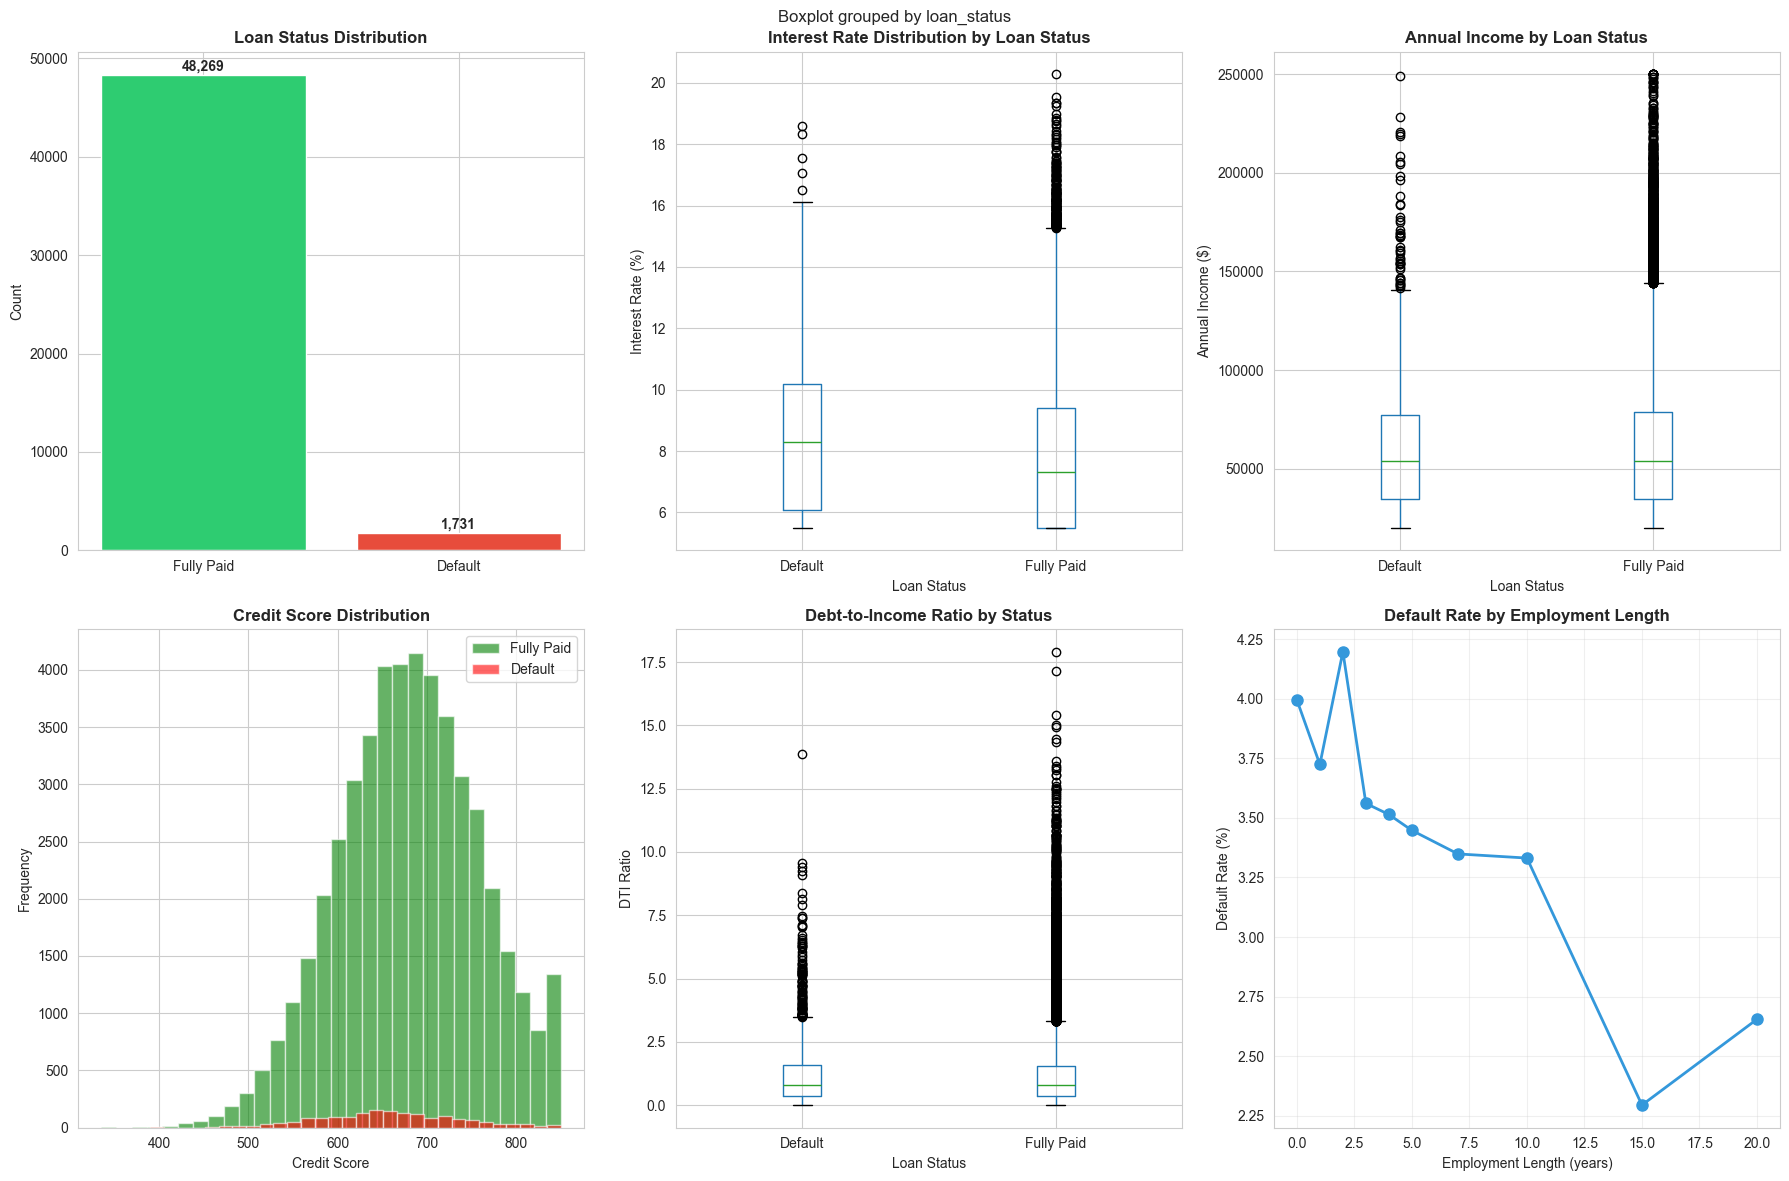

In [10]:
# Create visualizations
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Credit Risk - Exploratory Data Analysis', fontsize=16, fontweight='bold')

# 1. Loan Status Distribution
ax1 = axes[0, 0]
status_counts = df['loan_status'].value_counts()
ax1.bar(status_counts.index, status_counts.values, color=['#2ecc71', '#e74c3c'])
ax1.set_title('Loan Status Distribution', fontweight='bold')
ax1.set_ylabel('Count')
for i, v in enumerate(status_counts.values):
    ax1.text(i, v + 500, f'{v:,}', ha='center', fontweight='bold')

# 2. Interest Rate vs Default
ax2 = axes[0, 1]
df.boxplot(column='interest_rate', by='loan_status', ax=ax2)
ax2.set_title('Interest Rate Distribution by Loan Status', fontweight='bold')
ax2.set_xlabel('Loan Status')
ax2.set_ylabel('Interest Rate (%)')
plt.sca(ax2)
plt.xticks(rotation=0)

# 3. Income vs Default
ax3 = axes[0, 2]
df.boxplot(column='annual_income', by='loan_status', ax=ax3)
ax3.set_title('Annual Income by Loan Status', fontweight='bold')
ax3.set_xlabel('Loan Status')
ax3.set_ylabel('Annual Income ($)')
plt.sca(ax3)
plt.xticks(rotation=0)

# 4. Credit Score Distribution
ax4 = axes[1, 0]
df[df['loan_status'] == 'Fully Paid']['credit_score'].hist(bins=30, alpha=0.6, 
                                                             label='Fully Paid', ax=ax4, color='green')
df[df['loan_status'] == 'Default']['credit_score'].hist(bins=30, alpha=0.6, 
                                                          label='Default', ax=ax4, color='red')
ax4.set_title('Credit Score Distribution', fontweight='bold')
ax4.set_xlabel('Credit Score')
ax4.set_ylabel('Frequency')
ax4.legend()

# 5. DTI vs Default
ax5 = axes[1, 1]
df.boxplot(column='dti', by='loan_status', ax=ax5)
ax5.set_title('Debt-to-Income Ratio by Status', fontweight='bold')
ax5.set_xlabel('Loan Status')
ax5.set_ylabel('DTI Ratio')
plt.sca(ax5)
plt.xticks(rotation=0)

# 6. Employment Length Impact
ax6 = axes[1, 2]
emp_default = df.groupby('employment_length')['loan_status_encoded'].mean() * 100
ax6.plot(emp_default.index, emp_default.values, marker='o', linewidth=2, markersize=8, color='#3498db')
ax6.set_title('Default Rate by Employment Length', fontweight='bold')
ax6.set_xlabel('Employment Length (years)')
ax6.set_ylabel('Default Rate (%)')
ax6.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('eda_analysis.png', dpi=300, bbox_inches='tight')
print("✓ EDA visualizations saved as 'eda_analysis.png'")

**FEATURE ENGINEERING**

In [11]:
# Create income buckets
df['income_bucket'] = pd.cut(df['annual_income'], 
                              bins=[0, 40000, 70000, 100000, 250000],
                              labels=['Low', 'Medium', 'High', 'Very High'])

# Create credit score categories
df['credit_grade'] = pd.cut(df['credit_score'],
                             bins=[0, 580, 670, 740, 850],
                             labels=['Poor', 'Fair', 'Good', 'Excellent'])

# Loan to income ratio
df['loan_to_income'] = (df['loan_amount'] / df['annual_income']).round(4)

# Credit utilization
df['credit_utilization'] = (df['revolving_balance'] / df['total_credit_limit'] * 100).clip(0, 100).round(2)

print("✓ Created new features:")
print("  - Income Bucket")
print("  - Credit Grade")
print("  - Loan to Income Ratio")
print("  - Credit Utilization")


✓ Created new features:
  - Income Bucket
  - Credit Grade
  - Loan to Income Ratio
  - Credit Utilization


**PREPARE DATA FOR MODELLING**

In [12]:
# Select features for modeling
feature_cols = ['loan_amount', 'annual_income', 'interest_rate', 'employment_length',
                'credit_score', 'dti', 'loan_term', 'open_credit_lines', 
                'loan_to_income', 'credit_utilization']

X = df[feature_cols].copy()
y = df['loan_status_encoded']

# Handle any remaining issues
X = X.fillna(X.median())

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                      random_state=42, stratify=y)

print(f"✓ Training set: {len(X_train):,} samples")
print(f"✓ Test set: {len(X_test):,} samples")
print(f"✓ Features used: {len(feature_cols)}")

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

✓ Training set: 40,000 samples
✓ Test set: 10,000 samples
✓ Features used: 10


**RISK PREDICTION MODEL**

In [13]:
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train_scaled, y_train)

print("✓ Model trained successfully")

# Feature importance
feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Coefficient': model.coef_[0]
}).sort_values('Coefficient', key=abs, ascending=False)

print("\n📊 Feature Importance (Top Risk Factors):")
print(feature_importance.to_string(index=False))

✓ Model trained successfully

📊 Feature Importance (Top Risk Factors):
           Feature  Coefficient
      credit_score    -0.204981
 employment_length    -0.135958
     interest_rate     0.078437
         loan_term    -0.077110
               dti     0.027248
credit_utilization    -0.018891
       loan_amount     0.014986
     annual_income    -0.009988
 open_credit_lines    -0.003429
    loan_to_income    -0.001277


**MODEL EVALUATION**


📈 Classification Report:
              precision    recall  f1-score   support

  Fully Paid       0.97      1.00      0.98      9654
     Default       0.00      0.00      0.00       346

    accuracy                           0.97     10000
   macro avg       0.48      0.50      0.49     10000
weighted avg       0.93      0.97      0.95     10000


🎯 ROC-AUC Score: 0.5961

📊 Confusion Matrix:
[[9654    0]
 [ 346    0]]

✓ Model evaluation charts saved as 'model_evaluation.png'


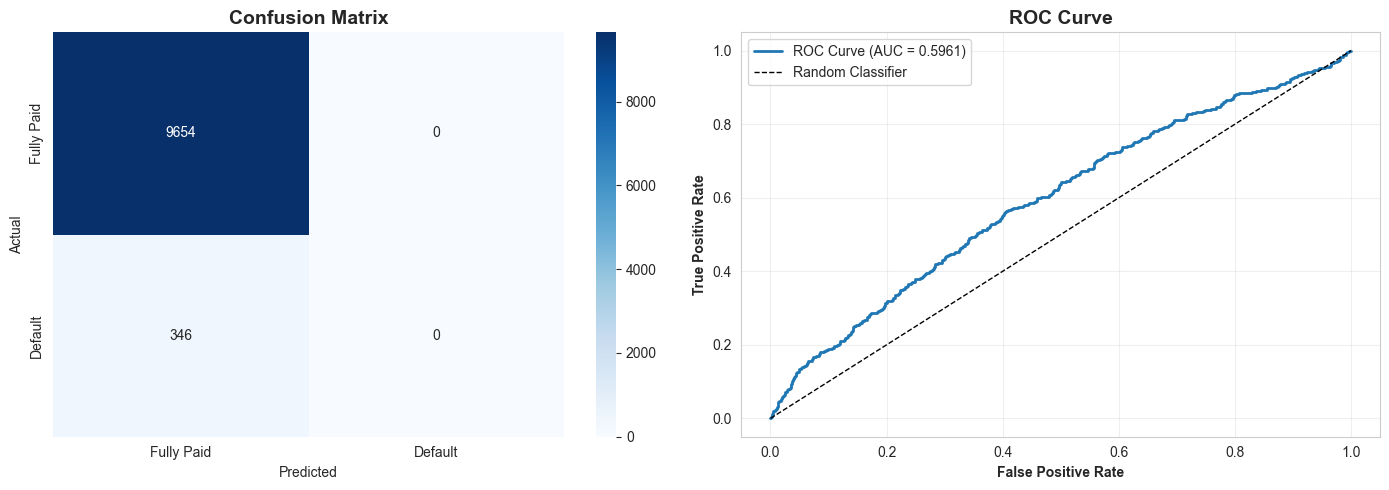

In [14]:
# Predictions
y_pred = model.predict(X_test_scaled)
y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

# Classification Report
print("\n📈 Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Fully Paid', 'Default']))

# ROC-AUC Score
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"\n🎯 ROC-AUC Score: {roc_auc:.4f}")

# Confusion Matrix
print("\n📊 Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Visualize results
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confusion Matrix Heatmap
ax1 = axes[0]
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1,
            xticklabels=['Fully Paid', 'Default'],
            yticklabels=['Fully Paid', 'Default'])
ax1.set_title('Confusion Matrix', fontweight='bold', fontsize=14)
ax1.set_ylabel('Actual')
ax1.set_xlabel('Predicted')

# ROC Curve
ax2 = axes[1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
ax2.plot(fpr, tpr, linewidth=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
ax2.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
ax2.set_xlabel('False Positive Rate', fontweight='bold')
ax2.set_ylabel('True Positive Rate', fontweight='bold')
ax2.set_title('ROC Curve', fontweight='bold', fontsize=14)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('model_evaluation.png', dpi=300, bbox_inches='tight')
print("\n✓ Model evaluation charts saved as 'model_evaluation.png'")

**INSIGHTS**

In [16]:
# Calculate key metrics
high_rate_defaults = df[df['interest_rate'] > 15]['loan_status_encoded'].mean()
low_rate_defaults = df[df['interest_rate'] <= 15]['loan_status_encoded'].mean()
rate_multiplier = high_rate_defaults / low_rate_defaults

low_income_defaults = df[df['annual_income'] < 50000]['loan_status_encoded'].mean()
high_income_defaults = df[df['annual_income'] >= 50000]['loan_status_encoded'].mean()
income_multiplier = low_income_defaults / high_income_defaults

print("\n🎯 KEY FINDINGS:")
print("-" * 80)
print(f"1. INTEREST RATE IMPACT:")
print(f"   • Customers with interest rate > 15%: {high_rate_defaults:.1%} default rate")
print(f"   • Customers with interest rate ≤ 15%: {low_rate_defaults:.1%} default rate")
print(f"   • High rates are {rate_multiplier:.2f}x more likely to default")

print(f"\n2. INCOME LEVEL IMPACT:")
print(f"   • Low income (<$50K): {low_income_defaults:.1%} default rate")
print(f"   • Higher income (≥$50K): {high_income_defaults:.1%} default rate")
print(f"   • Low income customers are {income_multiplier:.2f}x more risky")

print(f"\n3. EMPLOYMENT STABILITY:")
emp_corr = df[['employment_length', 'loan_status_encoded']].corr().iloc[0, 1]
print(f"   • Correlation with default: {emp_corr:.3f}")
print(f"   • Longer employment history reduces risk")

print(f"\n4. CREDIT UTILIZATION:")
util_default = df.groupby(pd.cut(df['credit_utilization'], bins=[0, 30, 50, 100]))['loan_status_encoded'].mean()
print(f"   • Low utilization (0-30%): {util_default.iloc[0]:.1%} default")
print(f"   • High utilization (50-100%): {util_default.iloc[-1]:.1%} default")

print("\n💡 BUSINESS RECOMMENDATIONS:")
print("-" * 80)
print("1. Implement risk-based pricing adjustments for high-risk segments")
print("2. Require additional documentation for customers with DTI > 35%")
print("3. Prioritize customers with credit scores > 700 and low DTI")
print("4. Consider employment verification for loans > $20,000")
print("5. Monitor credit utilization as an early warning indicator")

print("\n📊 PORTFOLIO RISK SUMMARY:")
print("-" * 80)
total_exposure = df['loan_amount'].sum()
default_exposure = df[df['loan_status'] == 'Default']['loan_amount'].sum()
print(f"Total Loan Portfolio: ${total_exposure:,.0f}")
print(f"At-Risk Exposure: ${default_exposure:,.0f} ({default_exposure/total_exposure:.1%})")


🎯 KEY FINDINGS:
--------------------------------------------------------------------------------
1. INTEREST RATE IMPACT:
   • Customers with interest rate > 15%: 6.4% default rate
   • Customers with interest rate ≤ 15%: 3.4% default rate
   • High rates are 1.86x more likely to default

2. INCOME LEVEL IMPACT:
   • Low income (<$50K): 3.5% default rate
   • Higher income (≥$50K): 3.4% default rate
   • Low income customers are 1.02x more risky

3. EMPLOYMENT STABILITY:
   • Correlation with default: -0.021
   • Longer employment history reduces risk

4. CREDIT UTILIZATION:
   • Low utilization (0-30%): 3.5% default
   • High utilization (50-100%): 3.2% default

💡 BUSINESS RECOMMENDATIONS:
--------------------------------------------------------------------------------
1. Implement risk-based pricing adjustments for high-risk segments
2. Require additional documentation for customers with DTI > 35%
3. Prioritize customers with credit scores > 700 and low DTI
4. Consider employment ve

**RESULTS**

In [17]:
# Save cleaned dataset
df.to_csv('loan_data_cleaned.csv', index=False)
print("✓ Cleaned dataset saved: 'loan_data_cleaned.csv'")

# Save model predictions
results_df = pd.DataFrame({
    'loan_id': df.iloc[X_test.index]['loan_id'],
    'actual_status': y_test,
    'predicted_status': y_pred,
    'default_probability': y_pred_proba
})
results_df.to_csv('model_predictions.csv', index=False)
print("✓ Predictions saved: 'model_predictions.csv'")

✓ Cleaned dataset saved: 'loan_data_cleaned.csv'
✓ Predictions saved: 'model_predictions.csv'
